In [1]:
!pip install patchify

In [2]:
import numpy as np 
import pandas as pd
import os
import cv2
import glob
from matplotlib import pyplot as plt

from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from pathlib import Path
Path('/kaggle/working/main_folder/512res_patches').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/main_folder/512res_patches/images').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/main_folder/512res_patches/masks').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/main_folder/data_for_training_and_testing').mkdir(parents=True, exist_ok=True)
root_directory = '/kaggle/input/potsdam/Potsdam'
patch_size = 512
img_dir="/kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB"
print("1")

1


In [4]:
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (512, 512, 3), step=512)  #Step=512 for 256 patches means no overlap
            new_name = image_name.replace('_RGB.tif', '')
            
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite("/kaggle/working/main_folder/512res_patches/images/"+
                               new_name+"patch_" + str(i) + str(j) + ".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)


Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_3_14_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_6_7_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_7_9_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_6_11_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_3_11_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_5_15_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_5_10_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_3_13_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_2_11_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_pot

In [5]:
mask_dir="/kaggle/input/potsdam/Potsdam/5_Labels_all"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (512, 512), step=512)  #Step=256 for 256 patches means no overlap
            new_name2 = mask_name.replace('_label.tif', '')
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite("/kaggle/working/main_folder/512res_patches/masks/"+
                               new_name2+"patch_"+str(i)+str(j)+".tif", single_patch_mask)

Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_9_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_6_15_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_3_10_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_5_12_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_8_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_6_13_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_6_8_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_2_10_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_13_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_10_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_2_13_l

In [6]:
train_img_dir = "/kaggle/working/main_folder/512res_patches/images/"
train_mask_dir = "/kaggle/working/main_folder/512res_patches/masks/"
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
len(msk_list), len(img_list)

(4598, 4598)

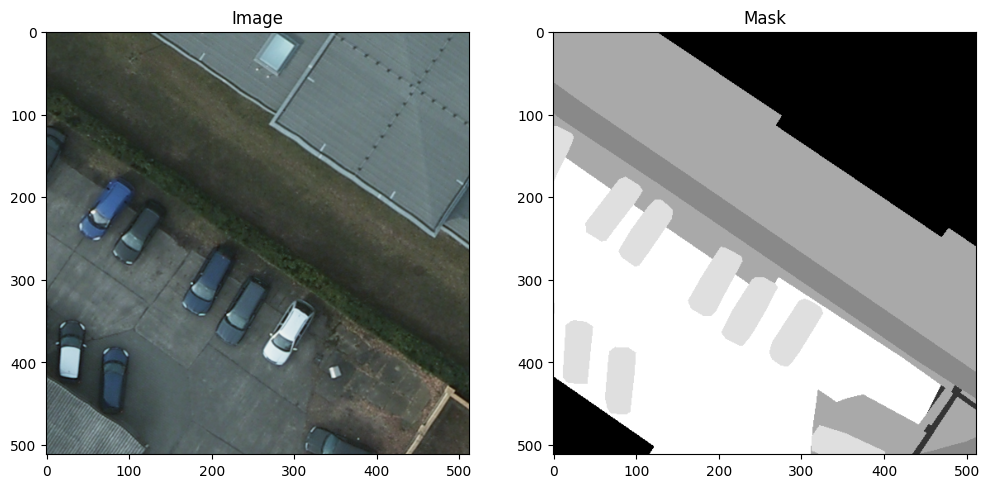

In [7]:
num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [8]:
# import shutil
# shutil.rmtree("/kaggle/working/main_folder/data_for_training_and_testing/val")
# shutil.rmtree("/kaggle/working/main_folder/data_for_training_and_testing/train")

In [9]:
from keras.utils import normalize
from keras.metrics import MeanIoU
!pip install split-folders

In [10]:
import splitfolders
input_folder = '/kaggle/working/main_folder/512res_patches'
output_folder = '/kaggle/working/main_folder/data_for_training_and_testing'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=32, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 9196 files [00:02, 3146.61 files/s]


In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
# import segmentation_models_pytorch as smp
from tensorflow.keras.metrics import MeanIoU
import random
import tensorflow as tf
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import albumentations as A

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
!pip install segmentation-models 

In [5]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

# !pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [6]:
import keras 
from keras.utils import normalize
from keras.metrics import MeanIoU
SIZE_X = 512 
SIZE_Y = 512
n_classes=6 #Number of classes for segmentation

In [36]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/kaggle/working/main_folder/data_for_training_and_testing/val/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/kaggle/working/main_folder/data_for_training_and_testing/val/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0) 
        mask = mask*(5/255)
        mask = mask.astype(np.uint8)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [37]:
train_images.shape, train_masks.shape 

((920, 512, 512, 3), (920, 512, 512))

In [38]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [39]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.6, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3 4 5]


In [40]:
X_train.shape, y_train.shape

((331, 512, 512, 3), (331, 512, 512, 1))

In [41]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [42]:
n_classes=6
activation='softmax'
LR = 0.0001
optim = "Adam"

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.65528844, 3.56154108, 1.07120728, 0.73141398, 6.44243807,
       0.57563383])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [43]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
# preprocess input
X_train2 = preprocess_input1(X_train)
X_test2 = preprocess_input1(X_test)

In [44]:
# define model
model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

In [46]:
history=model.fit(X_train2, 
          y_train_cat,
          batch_size=4, 
          epochs=20,
          verbose=1,
          validation_data=(X_test2, y_test_cat))

Epoch 1/20
83/83 [==============================] - 109s 905ms/step - loss: 0.3363 - accuracy: 0.4822 - iou_score: 0.2836 - f1-score: 0.4060 - val_loss: 1.4563 - val_accuracy: 0.2263 - val_iou_score: 0.0422 - val_f1-score: 0.0687
Epoch 2/20
83/83 [==============================] - 60s 719ms/step - loss: 0.1209 - accuracy: 0.5753 - iou_score: 0.3689 - f1-score: 0.5020 - val_loss: 1.4211 - val_accuracy: 0.2429 - val_iou_score: 0.0491 - val_f1-score: 0.0782
Epoch 3/20
83/83 [==============================] - 59s 712ms/step - loss: 0.1517 - accuracy: 0.5379 - iou_score: 0.3429 - f1-score: 0.4761 - val_loss: 0.5452 - val_accuracy: 0.3874 - val_iou_score: 0.1849 - val_f1-score: 0.2831
Epoch 4/20
83/83 [==============================] - 60s 721ms/step - loss: 0.0926 - accuracy: 0.5843 - iou_score: 0.3766 - f1-score: 0.5095 - val_loss: 1.4154 - val_accuracy: 0.1723 - val_iou_score: 0.0532 - val_f1-score: 0.0867
Epoch 5/20
83/83 [==============================] - 60s 724ms/step - loss: 0.0834 -

In [47]:
# Evaluate the model on the test set
evaluation = model.evaluate(x=X_test2, y= y_test_cat, batch_size=8)

# Extract the accuracy from the evaluation
accuracy = evaluation[1] * 100  # Assuming accuracy is the second metric

# Print the accuracy
print(f"Test set accuracy: {accuracy:.2f}%")

12/12 [==============================] - 6s 412ms/step - loss: -0.2003 - accuracy: 0.7032 - iou_score: 0.4950 - f1-score: 0.6333
Test set accuracy: 70.32%


In [48]:
model.save('FPN_512_res34_backbone_20epochss.hdf5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


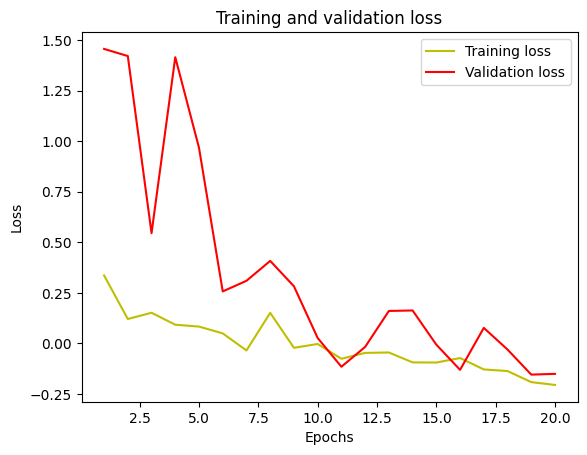

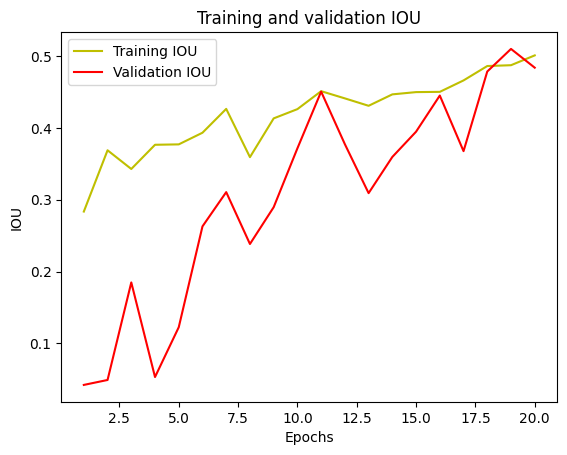

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [50]:
xx, xx_test, yy, yy_test = train_test_split(X_test, y_test, test_size = 0.1, random_state = 0)
#IOU
y_pred=model.predict(xx_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(yy_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 14s 14s/step
Mean IoU = 0.54968876


In [51]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[0,5]+ values[1,5]+ values[2,5])

print("IoU for class1: Building is: ", class1_IoU)
print("IoU for class2: Impervious Surface is: ", class2_IoU)
print("IoU for class3: Trees is: ", class3_IoU)
print("IoU for class4: Low Vegetation is: ", class4_IoU)
print("IoU for class5: Car is: ", class5_IoU)
print("IoU for class6: Clutter/Background is: ", class6_IoU)

[[5.19803e+05 2.19860e+04 5.97300e+03 1.68000e+03 0.00000e+00 3.72000e+03]
 [1.41420e+04 2.65250e+04 6.96500e+03 5.71200e+03 0.00000e+00 1.78860e+04]
 [9.55200e+03 6.18500e+03 2.18713e+05 5.14450e+04 2.29000e+02 1.38480e+04]
 [2.52650e+04 2.34330e+04 4.67200e+04 7.15099e+05 1.40000e+01 1.59940e+04]
 [4.80100e+03 5.35000e+03 2.10000e+01 6.66000e+02 3.39780e+04 2.56300e+03]
 [2.86909e+05 6.32300e+03 3.36440e+04 2.71430e+04 4.60400e+03 4.64549e+05]]
IoU for class1: Building is:  0.8686533
IoU for class2: Impervious Surface is:  0.25274423
IoU for class3: Trees is:  0.6329362
IoU for class4: Low Vegetation is:  0.82256365
IoU for class5: Car is:  0.7656324
IoU for class6: Clutter/Background is:  0.56181014


1/1 [==============================] - 0s 25ms/step


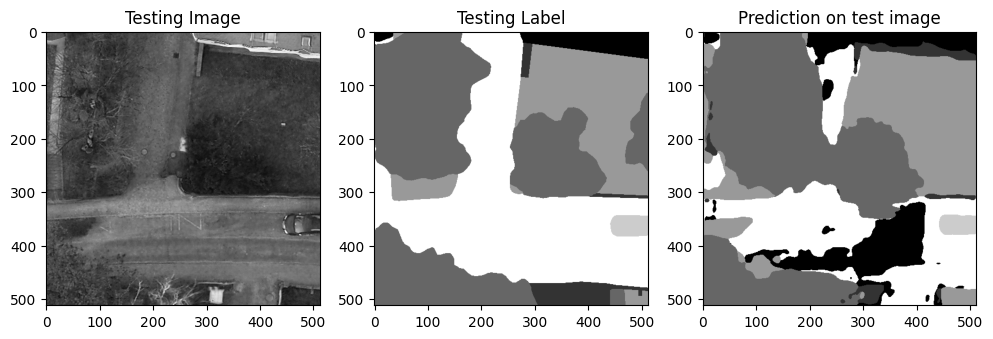

In [65]:
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()